In [1]:
import pandas as pd
import numpy as np
import os,sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import random
from collections import Counter, defaultdict
from tqdm import tqdm

In [2]:
path = os.getcwd()
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2014*","*csv"))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2015*","*csv")))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2016*","*csv")))
train = pd.DataFrame()
for f in files:
    try:
        if train.empty:
            train = pd.read_csv(f)
        else:
            train = pd.concat([train,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20140101-20141231\beijing_all_20141231.csv. Message is: Error tokenizing data. C error: Expected 3 fields in line 34, saw 5

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161231.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161231.csv. Message is: No columns to parse from file


In [3]:
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2017*","*csv"))
test = pd.DataFrame()
for f in files:
    try:
        if test.empty:
            test = pd.read_csv(f)
        else:
            test = pd.concat([test,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

In [4]:
train = train[~((train['type']=='PM2.5')&(train['门头沟']>2000))]

In [5]:
def preprocess(df):
    #convert date and hour columns into a Datetime index
    df['Datetime'] = pd.to_datetime(df['date'],format='%Y%m%d')+pd.to_timedelta(df['hour'].astype(int), unit='H')
    df = df.set_index('Datetime')
    df = df.drop(columns=['date','hour'])
    #remove AQI and all pollutants with suffix '_24h'
    pollutant = set(df.type)
    pollutant.remove('AQI')
    pollutant = [p for p in pollutant if '24h' not in p]
    df = df.loc[df['type'].isin(pollutant)]
    return df

In [6]:
train = preprocess(train)
test = preprocess(test)

In [36]:
def process_one_location(df, location, impute = False, take_log=True, take_diff=True, n_lag=3):
    subset = df.loc[:,['type',location]]
    subset.sort_values(by = ['Datetime'])
    subset = subset.pivot_table(values=location, index=[df.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

    subset_augmented = subset.asfreq('h')
    
    if take_log:
        subset_augmented['PM2.5'] = subset_augmented['PM2.5'].map(lambda x: np.log(x))
    
    if take_diff:
        subset_notna_index = (subset_augmented["PM2.5"]-subset_augmented["PM2.5"].shift(1)).notna() #record which index is NaN before imputation
    else:
        subset_notna_index = subset_augmented["PM2.5"].notna() #record which index is NaN before imputation
    
    truey_notna_index = subset_augmented["PM2.5"].notna() #record which index is NaN before imputation
    
    if impute:
        subset_augmented = subset_augmented.interpolate(method = 'ffill')#fill foward, to aviod leakage
    
    subset_augmented = feature_engineering(subset_augmented,n_lag,take_diff)

    subset_augmented['location'] = location
    true_y =  subset_augmented[["PM2.5",'location']]
    true_y.loc[~truey_notna_index,'PM2.5'] = np.nan #set the imputed target back to NaN
    
    if take_diff:
        subset_augmented['target'] = subset_augmented['PM2.5_diff']
        subset_augmented.loc[~subset_notna_index,'target'] = np.nan #set the imputed target back to NaN
        subset_augmented = subset_augmented.drop(columns=['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff','PM2.5','PM10','SO2','CO','NO2','O3'])
    else:
        subset_augmented['target'] = subset_augmented['PM2.5']
        subset_augmented.loc[~subset_notna_index,'target'] = np.nan #set the imputed target back to NaN
        subset_augmented = subset_augmented.drop(columns=['PM2.5','PM10','SO2','CO','NO2','O3'])
    
    return subset_augmented, true_y
    
def feature_engineering(subset_augmented, n_lag, take_diff=True):
    if take_diff:
        subset_augmented["PM2.5_diff"] = subset_augmented["PM2.5"]-subset_augmented["PM2.5"].shift(1)
        subset_augmented["PM10_diff"] = subset_augmented["PM10"]-subset_augmented["PM10"].shift(1)
        subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(24)
#         subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(1)
        subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(24)
#         subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(1)
        subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(24)
#         subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(1)
        subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(24)
#         subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(1)
    
    subset_augmented = create_lag(n_lag,subset_augmented,take_diff)
    
    subset_augmented = calculate_rolling_stat(subset_augmented,take_diff)
    
    return subset_augmented
        
def create_lag(n_lag, subset_augmented,take_diff=True):
    if take_diff:
        col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    else:
        col = ['PM2.5','PM10','SO2','CO','NO2','O3']
    for lag in range(1,n_lag+1):
        tmp = subset_augmented[col].shift(lag)
        tmp.columns=[f'{c}_lag_{lag}' for c in col]
        subset_augmented = pd.concat([subset_augmented,tmp],axis=1)
    
    #additional lags for PM2.5  
    for lag in range(n_lag+1,24): #has great predictive power
        tmp = pd.DataFrame(subset_augmented[col[0]].shift(lag))
        tmp.columns = [f'{col[0]}_lag_{lag}']
        subset_augmented = pd.concat([subset_augmented,tmp],axis=1)
        
    return subset_augmented

def calculate_rolling_stat(res,take_diff=True):
    if take_diff:
        col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    else:
        col = ['PM2.5','PM10','SO2','CO','NO2','O3']
    for p in col:
        res[f'{p}_daily_mean'] = res[p].rolling(24,min_periods=1).mean()
        res[f'{p}_daily_median'] = res[p].rolling(24,min_periods=1).median()
        res[f'{p}_daily_std'] = res[p].rolling(24,min_periods=1).std()
        res[f'{p}_weekly_mean'] = res[p].rolling(24*7,min_periods=1).mean()
        res[f'{p}_weekly_median'] = res[p].rolling(24*7,min_periods=1).median()
        res[f'{p}_weekly_std'] = res[p].rolling(24*7,min_periods=1).std()
        res[f'{p}_monthly_mean'] = res[p].rolling(24*30,min_periods=1).mean()
        res[f'{p}_monthly_median'] = res[p].rolling(24*30,min_periods=1).median()
        res[f'{p}_monthly_std'] = res[p].rolling(24*30,min_periods=1).std()
    return res

In [104]:
IS_TAKING_LOG=False
IS_TAKING_DIFF=True
IS_IMPUTE = True

In [105]:
alldata = pd.DataFrame()
allTarget = pd.DataFrame()
for l in train.columns[1:]:
    subset,true_y = process_one_location(train,l,impute = IS_IMPUTE, take_log=IS_TAKING_LOG, take_diff=IS_TAKING_DIFF,n_lag=3)
    alldata = pd.concat([alldata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTarget = pd.concat([allTarget,true_y])

In [106]:
#In order to calcualte rolling window statistics, we append the last month data from training dataset to our test dataset.
test_new = pd.concat([train.iloc[train.index>'2016-12-01'],test])
allTestdata = pd.DataFrame()
allTestTarget = pd.DataFrame()
for l in test_new.columns[1:]:
    subset,true_y = process_one_location(test_new,l,impute = IS_IMPUTE,take_log=IS_TAKING_LOG, take_diff=IS_TAKING_DIFF,n_lag=3)
    allTestdata = pd.concat([allTestdata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTestTarget = pd.concat([allTestTarget,true_y])

In [107]:
# if IS_TAKING_DIFF:
#     alldata = alldata.drop(columns=['PM10_diff_lag_1','PM10_diff_lag_2','PM10_diff_lag_3'])
# else:
#     alldata = alldata.drop(columns=['PM10_lag_1','PM10_lag_2','PM10_lag_3'])

# if IS_TAKING_DIFF:
#     allTestdata = allTestdata.drop(columns=['PM10_diff_lag_1','PM10_diff_lag_2','PM10_diff_lag_3'])
# else:
#     allTestdata = allTestdata.drop(columns=['PM10_lag_1','PM10_lag_2','PM10_lag_3'])

In [108]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale

In [109]:
N_NEIGHBORS_MAX = 15

class Neighbors:
    def __init__(self, 
                 pivot: pd.DataFrame, 
                 name: str,
                 p: float, 
                 metric: str = 'minkowski', 
                 exclude_self: bool = False):
        self.exclude_self = exclude_self
        self.p = p
        self.metric = metric
        self.name=name
        
        if metric == 'random':
            n_queries = len(pivot)
            self.neighbors = np.random.randint(n_queries, size=(n_queries, N_NEIGHBORS_MAX))
        else:
            nn = NearestNeighbors(
                n_neighbors=N_NEIGHBORS_MAX, 
                p=p, 
                metric=metric, 
            )
            nn.fit(pivot)
            _, self.neighbors = nn.kneighbors(pivot, return_distance=True)

        self.columns = self.index = self.feature_values = self.feature_col = None

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str):
        feature_pivot = df.pivot(columns='location',values=feature_col)
#         feature_pivot = feature_pivot.fillna(feature_pivot.mean())

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[:, self.neighbors[:, i]]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col

    def make_nn_feature(self, n=5, agg=np.mean):
  
        start = 1 if self.exclude_self else 0

        pivot_aggs = pd.DataFrame(
            agg(self.feature_values[start:n,:,:], axis=0), 
            columns=self.columns, 
            index=self.index
        )

        dst = pivot_aggs.unstack().reset_index(0)
        
        dst.columns = ['location',  f'{self.feature_col}_nn{n}_{self.name}_{agg.__name__}']
        return dst


In [110]:
location_neighbors = []

pivot = allTarget[["PM2.5","location"]].pivot(columns='location')
pivot = pivot.ffill().bfill()
# pivot = pd.DataFrame(minmax_scale(pivot))

location_neighbors.append(Neighbors(
            pivot.transpose(), 
            name='level',
            p = 1, 
            metric = 'minkowski',
            exclude_self = True
))

pivot = alldata[['PM2.5_diff_daily_std','location']].pivot(columns='location')
pivot = pivot.ffill().bfill()

location_neighbors.append(Neighbors(
            pivot.transpose(), 
            name='vol',
            p = 1, 
            metric = 'minkowski',
            exclude_self = True
))

In [111]:
def make_nn_features(df,nn,feature_col,locations,top_n=5,agg=np.mean):
    res = pd.DataFrame()
    for p in feature_col:
        nn.rearrange_feature_values(df,p)
        tmp = nn.make_nn_feature(top_n, agg)
        if res.empty:
            res = tmp
        else:
            col = tmp.columns[-1]
            res[col] = tmp[col]
    newDF = pd.DataFrame()
    for l in locations:
        tmp = pd.merge(res[res['location']==l].drop(columns=['location']),df[df['location']==l],left_index=True, right_index=True)
        newDF = pd.concat([newDF,tmp])
    del res, tmp
    gc.collect()
    return newDF

In [112]:
cols = alldata.columns[:-2]
cols = [ c for c in cols if 'PM2.5' in c]

In [113]:
for nn in location_neighbors:
    for n in [3,5,10,15]: #number of neighbors
        alldata = make_nn_features(alldata,nn,cols,train.columns[1:],n)
        allTestdata = make_nn_features(allTestdata,nn,cols,train.columns[1:],n)

In [114]:
alldata = alldata[alldata.index>'2014-04-03']   #starting from April 3rd for complete data
allTarget = allTarget[allTarget.index>'2014-04-03']   #starting from April 3rd for complete data

In [115]:
allTestdata = allTestdata[allTestdata.index>='2017-01-01']
allTestTarget = allTestTarget[allTestTarget.index>='2017-01-01']

In [116]:
def filter_na(data,true_y,locations):
    res = pd.DataFrame()
    res_test = pd.DataFrame()
    for l in locations:
        subset = data[data['location']==l]
        testing_y = true_y[true_y['location']==l]
        train_notna_index = subset['target'].notna()
        subset = subset[train_notna_index]
        testing_y = testing_y[train_notna_index]
        
        res = pd.concat([res,subset])
        res_test = pd.concat([res_test,testing_y])
    return res, res_test

In [117]:
alldata_noNA, allTarget_noNA = filter_na(alldata,allTarget,train.columns[1:])

allTestdata_noNA, allTestTarget_noNA = filter_na(allTestdata,allTestTarget,train.columns[1:])

alldata_noNA['location'] = alldata_noNA['location'].astype('category')
encode_mapping = dict( enumerate(alldata_noNA['location'].cat.categories ) )
alldata_noNA['location'] = alldata_noNA['location'].cat.codes
allTestdata_noNA['location'] = allTestdata_noNA['location'].astype('category')
allTestdata_noNA['location'] = allTestdata_noNA['location'].cat.codes

In [118]:
def add_freq_features(df): 
    timestamp_seconds = df.index.map(pd.Timestamp.timestamp)

    hours = 60*60
    days = 24*hours
    weeks = 24*7*hours
    months = 24*30*hours
    years = 24*30*12*hours

    df['days_sin'] = np.sin(timestamp_seconds * (2 * np.pi / days))
    df['days_cos'] = np.cos(timestamp_seconds * (2 * np.pi / days))
    df['weeks_sin'] = np.sin(timestamp_seconds * (2 * np.pi / weeks))
    df['weeks_cos'] = np.cos(timestamp_seconds * (2 * np.pi / weeks))
    df['months_sin'] = np.sin(timestamp_seconds * (2 * np.pi / months))
    df['months_cos'] = np.cos(timestamp_seconds * (2 * np.pi / months))
    df['years_sin'] = np.sin(timestamp_seconds * (2 * np.pi / years))
    df['years_cos'] = np.cos(timestamp_seconds * (2 * np.pi / years))

    cols_at_end = ['location', 'target']
    df = df[[c for c in df if c not in cols_at_end] 
            + [c for c in cols_at_end if c in df]]
    return df

alldata_noNA = add_freq_features(alldata_noNA)
allTestdata_noNA = add_freq_features(allTestdata_noNA)

In [119]:
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [120]:
import lightgbm as lgb
seed0=617
lgb_params = {
            'objective': 'regression',
            'subsample': 0.72,
            'subsample_freq': 5,
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting_type": "gbdt",
            "metric": 'rmse',
            "verbosity": -1,
            'feature_fraction': 0.5,
            'lambda_l1': 0.5,
            'lambda_l2': 1.0,
            'random_state': seed0,
            'feature_fraction_seed': seed0,
            'bagging_seed': seed0,
         }

In [121]:
def train_lgb(data,test,label,params,n_splits=5):
    skf = StratifiedKFold(n_splits)

    y_oof = np.zeros(data.shape[0])
    
    test_predictions = np.zeros(test.shape[0])

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = data.columns[:-1]
    mean_score = []
    
    for fold_n, (train_index, valid_index) in enumerate(skf.split(data,label)):
        print(f'Fold: {fold_n+1}')
        X_train, X_valid = data.iloc[train_index].loc[:,data.columns!="target"],data.iloc[valid_index].loc[:,data.columns!="target"]
        y_train, y_valid = data.iloc[train_index].loc[:,"target"], data.iloc[valid_index].loc[:,"target"]

        dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature = ['location'])
        dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature = ['location'])

        clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=500)

        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
        y_oof[valid_index] = y_pred_valid
        
        #Predict the test set       
        test_predictions += clf.predict(test.loc[:,data.columns!="target"],num_iteration=clf.best_iteration) / n_splits
        val_score = np.sqrt(mean_squared_error(y_pred_valid, y_valid))
        print(f'val rmse score is {val_score}')
        mean_score.append(val_score)

        del X_train, X_valid, y_train, y_valid
        gc.collect()

    print(f'mean rmse score over folds is {np.mean(mean_score)}')
    
    return y_oof, feature_importances,test_predictions

In [122]:
n_splits = 5
predicted, feature_importances,test_predictions = train_lgb(alldata_noNA,allTestdata_noNA,alldata_noNA['location'],lgb_params, n_splits)

Fold: 1
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 11.2305	valid_1's rmse: 12.5085
[1000]	training's rmse: 9.21649	valid_1's rmse: 11.5222
[1500]	training's rmse: 7.86876	valid_1's rmse: 10.8026
[2000]	training's rmse: 6.86432	valid_1's rmse: 10.2666
[2500]	training's rmse: 6.07788	valid_1's rmse: 9.85357
[3000]	training's rmse: 5.44254	valid_1's rmse: 9.53286
[3500]	training's rmse: 4.91256	valid_1's rmse: 9.26886
[4000]	training's rmse: 4.47359	valid_1's rmse: 9.05748
[4500]	training's rmse: 4.10202	valid_1's rmse: 8.88893
[5000]	training's rmse: 3.78126	valid_1's rmse: 8.75349
[5500]	training's rmse: 3.50396	valid_1's rmse: 8.63358
[6000]	training's rmse: 3.25997	valid_1's rmse: 8.53725
[6500]	training's rmse: 3.04575	valid_1's rmse: 8.45307
[7000]	training's rmse: 2.85529	valid_1's rmse: 8.37858
[7500]	training's rmse: 2.68702	valid_1's rmse: 8.31722
[8000]	training's rmse: 2.53466	valid_1's rmse: 8.26324
[8500]	training's rmse: 2.39774	vali

In [123]:
def process_prediction(predicted, true_y, take_log=True, take_diff=True):
    true_y['predicted'] = predicted
    if take_diff:
        true_y['prediction'] = true_y['predicted'] + true_y['PM2.5_y']
    else:
        true_y['prediction'] = true_y['predicted']
        
    true_y['prediction'] = true_y['prediction'].map(lambda x: max(x,0)) # floor at 0
    true_y['prediction'] = true_y['prediction'].map(lambda x: min(x,1000)) # cap at 1000
    
    if take_log:
        true_y['prediction']=true_y['prediction'].map(lambda x: np.exp(x))
        true_y['PM2.5_y']=true_y['PM2.5_y'].map(lambda x: np.exp(x))
        true_y['PM2.5']=true_y['PM2.5'].map(lambda x: np.exp(x))

    true_y.dropna(inplace=True)

In [124]:
process_prediction(predicted,allTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)
process_prediction(test_predictions,allTestTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)

print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTarget_noNA["prediction"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTestTarget_noNA["prediction"],allTestTarget_noNA["PM2.5"]))}')

print(f'In sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTarget_noNA["PM2.5_y"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTestTarget_noNA["PM2.5_y"],allTestTarget_noNA["PM2.5"]))}')

In sample RMSE for LightGBM method is 10.04740615122957
Out of sample RMSE for LightGBM method is 12.445125130090132
In sample RMSE for Naive method is 19.967505740638842
Out of sample RMSE for Naive method is 21.897577293680712


In [125]:
print(f'In sample RMSE for LightGBM method is {r2_score(allTarget_noNA["prediction"],allTarget_noNA["PM2.5"])}')
print(f'Out of sample RMSE for LightGBM method is {r2_score(allTestTarget_noNA["prediction"],allTestTarget_noNA["PM2.5"])}')

print(f'In sample RMSE for Naive method is {r2_score(allTarget_noNA["PM2.5_y"],allTarget_noNA["PM2.5"])}')
print(f'Out of sample RMSE for Naive method is {r2_score(allTestTarget_noNA["PM2.5_y"],allTestTarget_noNA["PM2.5"])}')

In sample RMSE for LightGBM method is 0.9850301524417124
Out of sample RMSE for LightGBM method is 0.9811794525447591
In sample RMSE for Naive method is 0.9403621340239634
Out of sample RMSE for Naive method is 0.9417088005212829


Text(0.5, 1.0, '40 TOP feature importance over 5 folds average')

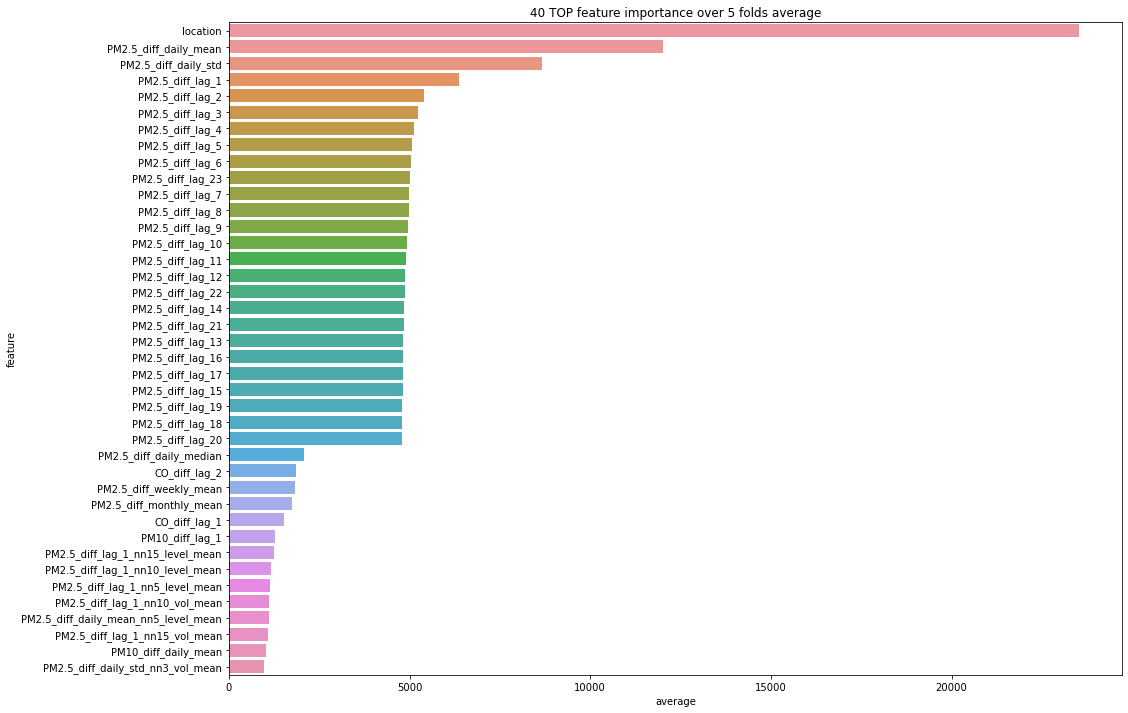

In [126]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(40), x='average', y='feature')
plt.title('40 TOP feature importance over {} folds average'.format(n_splits))

In [127]:
allTarget_noNA.to_csv('insample_knn_lr1_ff.csv',index=True)

In [128]:
allTestTarget_noNA.to_csv('outsample_knn_lr1_ff.csv',index=True)

In [103]:
allTestTarget_noNA

,PM2.5,location,PM2.5_y,predicted,prediction
Datetime,,,,,
2017-01-01 23:00:00,470.0,东四,469.0,1.961505,470.961505
2017-01-02 00:00:00,458.0,东四,470.0,-13.657701,456.342299
2017-01-02 01:00:00,477.0,东四,458.0,18.207795,476.207795
2017-01-02 02:00:00,467.0,东四,477.0,-10.461727,466.538273
2017-01-02 03:00:00,405.0,东四,467.0,-43.338441,423.661559
...,...,...,...,...,...
2017-04-29 19:00:00,59.0,东四环,36.0,22.384842,58.384842
2017-04-29 20:00:00,44.0,东四环,59.0,-13.130793,45.869207
2017-04-29 21:00:00,56.0,东四环,44.0,12.051099,56.051099
